## Import dependecies

In [44]:
import sys
import time
import warnings
import logging
import random
import json
from os.path import join, basename, splitext, isfile
from os import listdir
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cooler
import cooltools

import hichew
from hichew.calling import boundaries, domains, clusters
from hichew.compute import normalize, d_scores, insulation_scores, silhouette
from hichew.loader import cool_files
from hichew.plot import clusters_dynamics, viz_opt_curves, viz_tads, _pca, _tsne


In [30]:
import logging
import time
import operator
import os
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation, MeanShift

from hichew.lib import utils

In [31]:
sns.set(context='paper', style='whitegrid')
warnings.filterwarnings("ignore")

In [32]:
%matplotlib inline

In [33]:
def _viz_tads_and_fountains_(df_tads, df_fountains, datasets, begin=0, end=100, ch='chrX', exp='3-4h', resolution=5000, is_insulation=False, percentile=99.9):
    """
    Function to vizualize TADs or TAD boundaries on the Hi-C matrices.
    :param df: dataframe with segmentation/clustering.
    :param datasets: python dictionary with loaded chromosomes and stages.
    :param begin: start bin for visualization
    :param end: end bin for visualization
    :param ch: chromosome of interest
    :param exp: stage of development by which we want to visualize segmentation/clustering.
    :param resolution: Hi-C resolution of your coolfiles.
    :param method: clustering method. Type in case of clusters=True.
    :param is_insulation: True in case of TAD boundaries annotation in df , False in case of TAD segmentation in df
    :param clusters: True if we want to vizualize clustering, False otherwise.
    :param colors: color pallet for clustering vizualization.
    :param percentile: percentile for cooler preparations and Hi-C vizualization.
    :return: --
    """
    # color_dict = {"#7bc8f6": "lightblue", "#76ff7b": "lightgreen", "#faee66": "yellowish", "#fc86aa": "pinky",  "#a8a495": "greyish", "#070d0d": "almost black", "#fd8d49": "orangeish", "#98568d": "purpleish"}
    color_tads = 'blue'
    color_fountains = 'lightgreen'
    
    df_tads_tmp = df_tads.query("ch=='{}'".format(ch))
    if df_fountains is not None:
        df_fountains_tmp = df_fountains.query("chrom=='{}'".format(ch))
    
    segments_tads = df_tads_tmp[['bgn', 'end']].values // resolution
    if df_fountains is not None:
        segments_fountains = df_fountains_tmp[['start', 'end']].values // resolution
    
    mtx_cor = datasets[exp][ch]
    np.fill_diagonal(mtx_cor, 0)
    plt.figure(figsize=[20, 20])
    sns.heatmap(np.log(mtx_cor[begin: end, begin: end] + 1), cmap="Reds", square=True, cbar=False,
                vmax=np.nanpercentile(mtx_cor, percentile))
    plt.xticks([])
    plt.yticks([])

    # plot boundaries
    for ii, seg in enumerate(segments_tads):
        if is_insulation:
            if seg[0] < end and seg[1] > begin:
                for i in range(1):
                    plt.plot(
                        [seg[0] + i - begin, seg[1] + i - begin],
                        [seg[0] - i - begin, seg[0] - i - begin],
                        color=color_tads, linewidth=7, label='boundary')
                    plt.plot(
                        [seg[1] + i - begin, seg[1] + i - begin],
                        [seg[0] - i - begin, seg[1] - i - begin],
                        color=color_tads, linewidth=7, label='boundary')
                    plt.plot(
                        [seg[0] + i - begin, seg[1] + i - begin],
                        [seg[0] + 1 - i - begin,
                         seg[0] + 1 - i - begin],
                        color=color_tads, linewidth=7, label='boundary')
                    plt.plot([seg[1] - 1 + i - begin,
                              seg[1] - 1 + i - begin],
                             [seg[0] - i - begin,
                              seg[1] - i - begin],
                             color=color_tads, linewidth=7, label='boundary')
        else:
            if seg[0] < end and seg[1] > begin:
                plt.plot([seg[0] - begin, seg[1] - begin], [seg[0] - begin, seg[0] - begin], color=color_tads, linewidth=7, label='boundary')
                plt.plot([seg[1] - begin, seg[1] - begin], [seg[0] - begin, seg[1] - begin], color=color_tads, linewidth=7, label='boundary')

    if df_fountains is not None:
        # plot fountains
        for ii, seg in enumerate(segments_fountains):
            if is_insulation:
                if seg[0] < end and seg[1] > begin:
                    for i in range(1):
                        plt.plot(
                            [seg[0] + i - begin, seg[1] + i - begin],
                            [seg[0] - i - begin, seg[0] - i - begin],
                            color=color_fountains, linewidth=7, label='fountain')
                        plt.plot(
                            [seg[1] + i - begin, seg[1] + i - begin],
                            [seg[0] - i - begin, seg[1] - i - begin],
                            color=color_fountains, linewidth=7, label='fountain')
                        plt.plot(
                            [seg[0] + i - begin, seg[1] + i - begin],
                            [seg[0] + 1 - i - begin,
                             seg[0] + 1 - i - begin],
                            color=color_fountains, linewidth=7, label='fountain')
                        plt.plot([seg[1] - 1 + i - begin,
                                  seg[1] - 1 + i - begin],
                                 [seg[0] - i - begin,
                                  seg[1] - i - begin],
                                 color=color_fountains, linewidth=7, label='fountain')
            else:
                if seg[0] < end and seg[1] > begin:
                    plt.plot([seg[0] - begin, seg[1] - begin], [seg[0] - begin, seg[0] - begin], color=color_fountains, linewidth=7, label='fountain')
                    plt.plot([seg[1] - begin, seg[1] - begin], [seg[0] - begin, seg[1] - begin], color=color_fountains, linewidth=7, label='fountain')


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    lgd = plt.legend(by_label.values(), by_label.keys(), title='Loci:', loc='upper right', prop={'size': 25})
    lgd.get_title().set_fontsize('25')

    plt.draw()
    plt.show()

## Specify parameters

In [101]:
resolution = 10000

fountains_path = '../arcuda/fountains/{}.bed'
boundaries_path = '../arcuda/boundaries/filtered/{}.csv'
coolers_path = '../arcuda/coolers/This2022/{}.mcool'

stages_fountains = ['Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                    'WT.danrer11-reduced.mapq_30.1000', 
                    'TR.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                    'Wild-Type_25.danrer11-reduced.mapq_30.1000']

stages_boundaries = ['sperm.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
                     'WT.danrer11-reduced.mapq_30.1000', 
                     'TR.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
                     'Wild-Type_25.danrer11-reduced.mapq_30.1000']

stages_all = ['sperm.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_2.75.danrer11-reduced.mapq_30.1000', 
              'WT.danrer11-reduced.mapq_30.1000', 
              'TR.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_5.3.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_11.danrer11-reduced.mapq_30.1000', 
              'Wild-Type_25.danrer11-reduced.mapq_30.1000']

################
i = 5 ##########
################

stage_to_call = coolers_path.format(stages_all[i])

In [102]:
stages_all[i]

'Wild-Type_11.danrer11-reduced.mapq_30.1000'

## Get data

#### Chromosomes

In [103]:
# chromosome armsizes

chromosome_armsizes_path = '../arcuda/genome/danRer11.armsizes.txt'
chromosome_armsizes_data = pd.read_csv(chromosome_armsizes_path)
chromosome_armsizes_data = chromosome_armsizes_data.iloc[:-1]
chromosomes = list(chromosome_armsizes_data.chrom.drop_duplicates())

#### Coolers

In [104]:
matrices, coolers = cool_files(stage_to_call, resolution=resolution, chromnames=chromosomes)

INFO:root:LOADER|COOL_FILES| List of coolfiles of interest: ['../arcuda/coolers/This2022/Wild-Type_11.danrer11-reduced.mapq_30.1000.mcool']
INFO:root:LOADER|COOL_FILES| Start loading coolfiles...
INFO:root:LOADER|COOL_FILES| Loading completed in 0m 22s


#### Fountains

In [105]:
if isfile(fountains_path.format(stages_all[i])):
    fountains_data = pd.read_csv(fountains_path.format(stages_all[i]), sep='\t', header=None)
    fountains_data.columns = ['chrom', 'start', 'end', 'unknown', 'sim']
else:
    fountains_data = None
    print('No fountains for stage {}'.format(stages_all[i]))

In [106]:
fountains_data.head()

,chrom,start,end,unknown,sim
0,chr24,2410000,2420000,126798,0.611457
1,chr2,34030000,34040000,9361,0.602479
2,chr18,37330000,37340000,101690,0.598924
3,chr20,26460000,26470000,110551,0.566440
4,chr2,27480000,27490000,8706,0.557273


#### Boundaries

In [107]:
if isfile(boundaries_path.format(stages_all[i])):
    boundaries_data = pd.read_csv(boundaries_path.format(stages_all[i]))
else:
    print('No boundaries for stage {}'.format(stages_all[i]))

In [108]:
boundaries_data.head()

,bgn,end,bs_threshold,window,ch,insulation_score,boundary_strength
0,100000,110000,0.9,130000,chr1,-0.397285,0.944418
1,670000,680000,0.9,130000,chr1,-0.410409,0.952325
2,1080000,1090000,0.9,130000,chr1,-0.575698,1.067238
3,1340000,1350000,0.9,130000,chr1,-1.164165,1.893459
4,1630000,1640000,0.9,130000,chr1,-0.458228,1.103504


## Visual inspection

* Fountains in green
* Boundaries in blue

In [109]:
j = 0

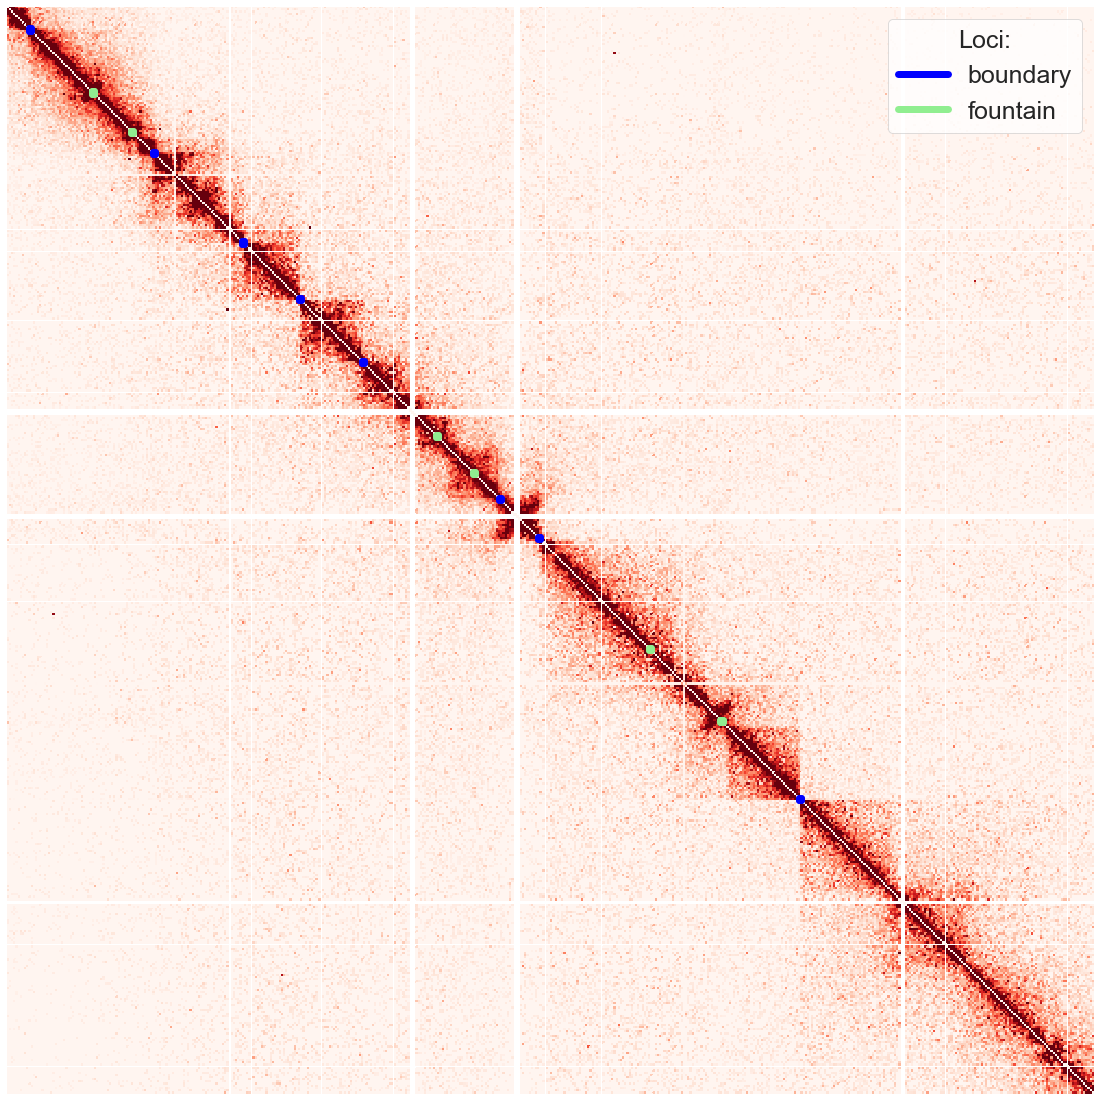

In [110]:
_viz_tads_and_fountains_(boundaries_data, fountains_data, matrices, begin=0, end=500, ch=chromosomes[j], exp=stages_all[i], 
         resolution=resolution, is_insulation=True, percentile=99.9)

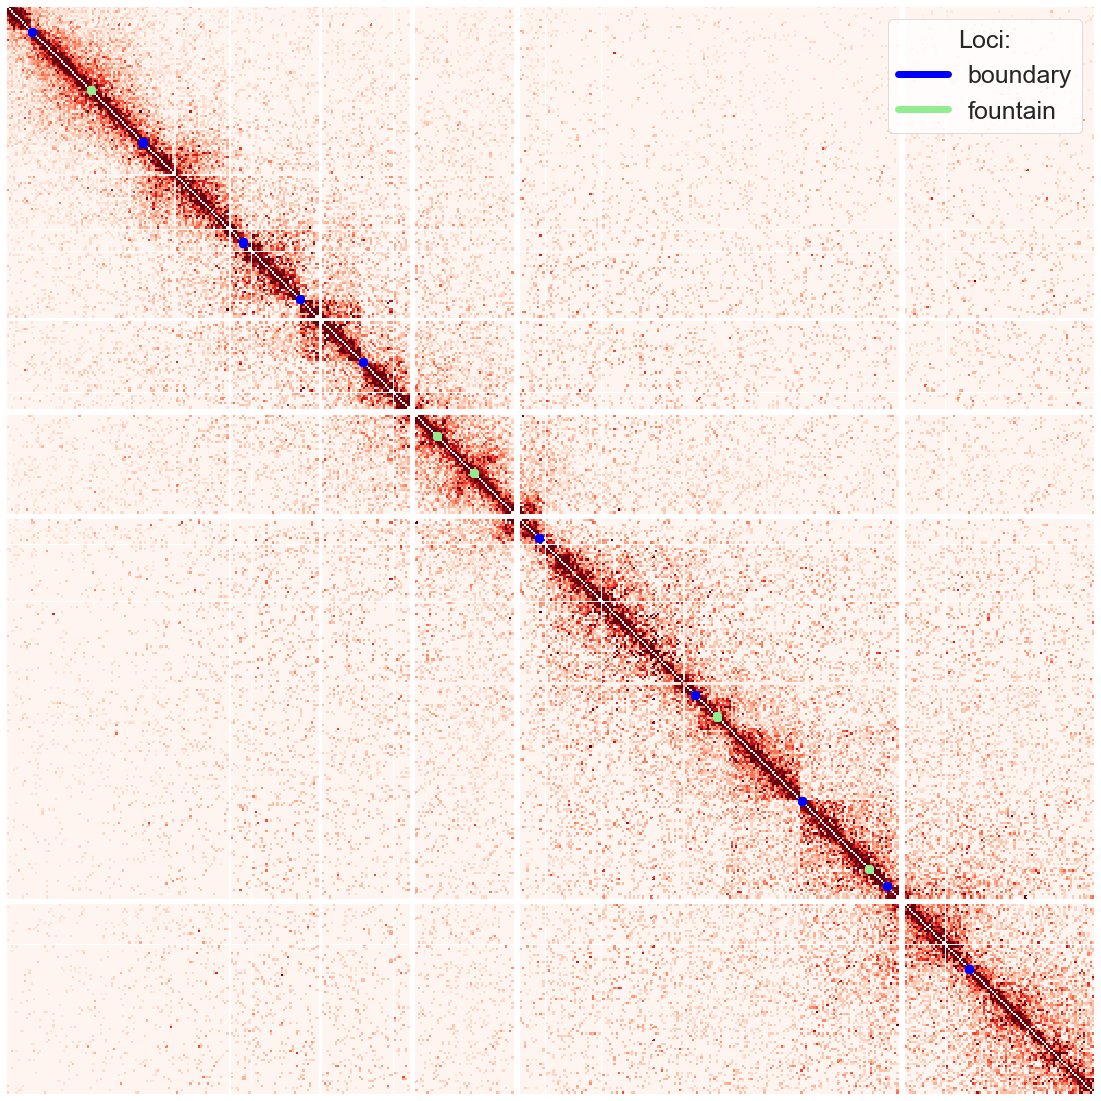

In [98]:
_viz_tads_and_fountains_(boundaries_data, fountains_data, matrices, begin=0, end=500, ch=chromosomes[j], exp=stages_all[i], 
         resolution=resolution, is_insulation=True, percentile=99.9)

**Fountains tend to be in the interior of the "TAD-like" structures (visual inspection).**